# 02. RAG Pipeline Implementation

In this notebook, we will:
1. Load the processed knowledge base (Parquet).
2. Generate embeddings for all chunks using `sentence-transformers`.
3. Build a FAISS index for fast retrieval.
4. Load the Gemma 2 2B model (quantized).
5. Implement the RAG pipeline (Retrieval + Generation).
6. Test the system.

In [ ]:
# ==========================================
# 1. Global Setup & Imports
# ==========================================
import os
import sys
import gc
import pandas as pd
import numpy as np
import torch
import faiss
from tqdm import tqdm
import tqdm.std
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from huggingface_hub import login

# Fix tqdm for notebooks
tqdm.pandas()

# Add src to path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Import configuration and utility functions
from src.config import (
    PROCESSED_DATA_PATH, 
    INDEX_PATH, 
    EMBEDDING_MODEL_NAME, 
    MODEL_NAME,
    TOP_K
)
from src.visualization import set_plot_style, plot_rag_retrieval_stats
from src.rag import RAGPipeline

# Set consistent style
set_plot_style()

# Check device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Configuration
FORCE_INDEXING = False

Using device: cuda


In [ ]:
# ==========================================
# 2. Load Knowledge Base
# ==========================================
# Hugging Face Login (Uncomment if needed)
# login() 

if not os.path.exists(PROCESSED_DATA_PATH):
    raise FileNotFoundError(f"Run notebook 01 first to generate {PROCESSED_DATA_PATH}")

df = pd.read_parquet(PROCESSED_DATA_PATH)
print(f"Loaded {len(df)} chunks.")
df.head(2)

In [ ]:
# ==========================================
# 3. Generate Embeddings
# ==========================================
# Check if we should skip
if not FORCE_INDEXING and os.path.exists(INDEX_PATH):
    print(f"Found existing index at {INDEX_PATH}. Skipping embedding generation.")
else:
    print(f"Loading embedding model: {EMBEDDING_MODEL_NAME}")
    embed_model = SentenceTransformer(EMBEDDING_MODEL_NAME, device=device)
    print("Generating embeddings...")

    # Manual batching for progress visibility
    batch_size = 32
    all_texts = df['text'].tolist()
    embeddings_list = []

    for i in tqdm(range(0, len(all_texts), batch_size), ascii=True, desc="Encoding", ncols=80):
        batch = all_texts[i : i + batch_size]
        batch_emb = embed_model.encode(batch, show_progress_bar=False, convert_to_numpy=True)
        embeddings_list.append(batch_emb)

    embeddings = np.vstack(embeddings_list)
    print(f"Embeddings shape: {embeddings.shape}")

Loading embedding model: all-MiniLM-L6-v2
Generating embeddings...


Encoding: 100%|###############################| 558/558 [00:45<00:00, 12.28it/s]

Embeddings shape: (17833, 384)


In [ ]:
# ==========================================
# 4. Build & Save FAISS Index
# ==========================================
if not os.path.exists(INDEX_PATH) or FORCE_INDEXING:
    d = embeddings.shape[1] # Dimension of embeddings
    index = faiss.IndexFlatL2(d) # L2 distance (Euclidean)
    index.add(embeddings)
    print(f"Total vectors in index: {index.ntotal}")

    # Save index
    faiss.write_index(index, INDEX_PATH)
    print(f"Index saved to {INDEX_PATH}")
else:
    print(f"Index already exists at {INDEX_PATH}. Skipping build.")

Total vectors in index: 17833
Index saved to c:\Users\matteucc\Desktop\Portfolio_improvement\Medical_question_answering\data\faiss_index.bin


In [ ]:
# ==========================================
# 5. Initialize RAG Pipeline
# ==========================================
# Clean up memory from the indexing phase
print("Cleaning up memory...")
try:
    del embed_model
    del embeddings
    del index
    del df
except NameError:
    pass
gc.collect()
torch.cuda.empty_cache()

# Initialize RAG Pipeline
print("Initializing RAG Pipeline...")
rag = RAGPipeline(device=device)
rag.load_resources()

Cleaning up memory...
Initializing RAG Pipeline...
--- Loading RAG Resources on CUDA ---
Loading Knowledge Base from: c:\Users\matteucc\Desktop\Portfolio_improvement\Medical_question_answering\data\knowledge_base.parquet
Loading FAISS Index from: c:\Users\matteucc\Desktop\Portfolio_improvement\Medical_question_answering\data\faiss_index.bin
Loading Embedding Model: all-MiniLM-L6-v2
Loading LLM: google/gemma-2-2b-it


Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.82s/it]


All resources loaded successfully.



--- Running 5 Test Cases ---

Test 1 [Acronyms (LCM)]: What are the symptoms of LCM?
Answer: The provided text describes the symptoms of LCM as follows:

* **During the first phase (biphasic febrile illness):**
    * Fever
    * Malaise
    * Lack of appetite
    * Muscle aches
    * Headache
    * Nausea and vomiting
* **Later phases (after the initial phase):**
    * Meningitis (fever, headache, stiff neck, etc.)
    * Encephalitis (drowsiness, confusion, sensory disturbances, etc.)
    * Myelitis (inflammation of the spinal cord)
    * Acute hydrocephalus (increased fluid on the brain)
    * Nerve deafness and arthritis

**Important Notes:**

* The symptoms of LCM can vary in severity and presentation.
* Some individuals may experience no symptoms, while others may have severe symptoms.
* LCM can be a serious condition, but most patients do not die from it. 


Let me know if you have any other questions.

Top Sources:
   1. [Dist: 0.74] Question: What are the symptoms of Lymphocytic

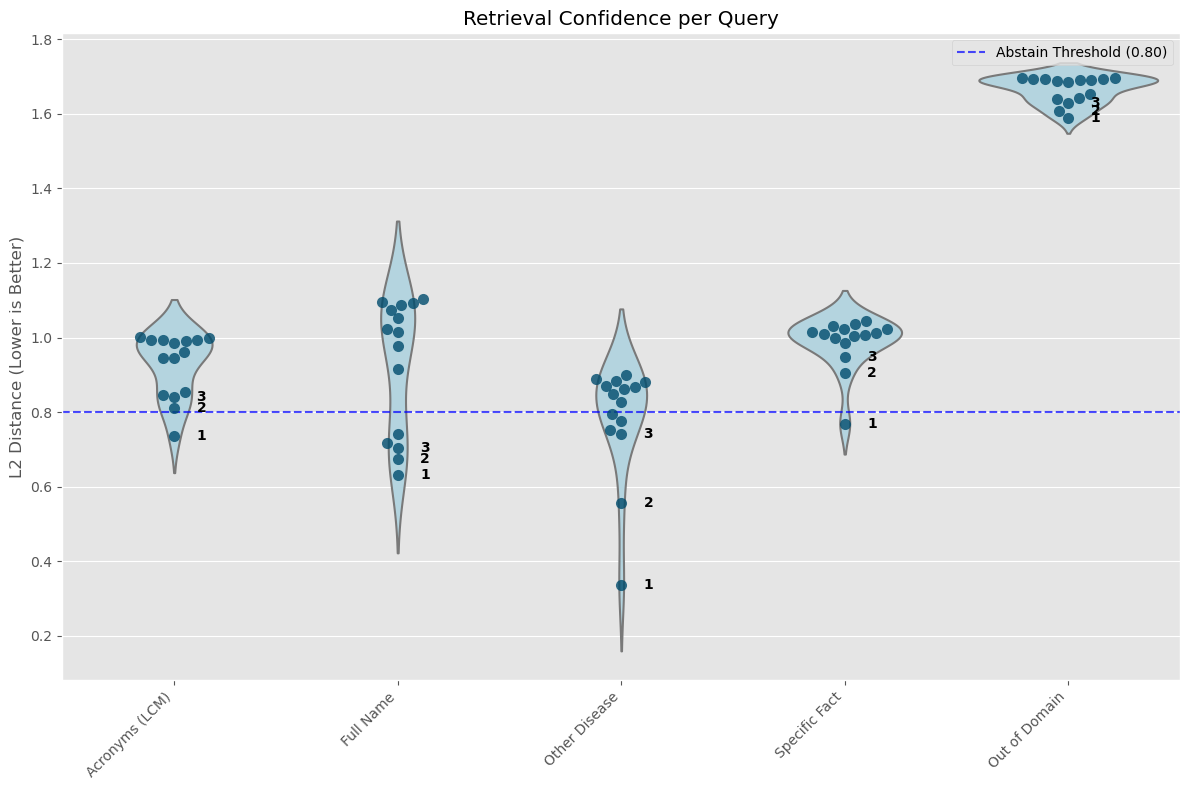

In [ ]:
# ==========================================
# 6. Comprehensive Testing
# ==========================================
import importlib
import src.visualization
importlib.reload(src.visualization)
from src.visualization import plot_rag_retrieval_stats

# Define Test Cases
test_queries = [
    ("What are the symptoms of LCM?", "Acronyms (LCM)"),
    ("How do humans typically get Lymphocytic Choriomeningitis?", "Full Name"),
    ("What is LCHAD deficiency?", "Other Disease"),
    ("How is LCM diagnosed?", "Specific Fact"),
    ("What is the capital of Mars?", "Out of Domain")
]

print(f"--- Running {len(test_queries)} Test Cases ---\n")

results_data = []
K_TEST = 15 

# Prepare output file
output_txt_path = '../output/rag_test_results.txt'
os.makedirs(os.path.dirname(output_txt_path), exist_ok=True)

with open(output_txt_path, 'w', encoding='utf-8') as f:
    f.write(f"--- Running {len(test_queries)} Test Cases ---\n\n")

    for i, (query, label) in enumerate(test_queries, 1):
        # Build output string
        case_output = f"Test {i} [{label}]: {query}\n"
        answer, sources = rag.generate_answer(query, k=K_TEST)
        case_output += f"Answer: {answer}\n\n"
        
        if sources:
            case_output += "Top Sources:\n"
            for rank, s in enumerate(sources[:3], 1): # Show top 3 sources
                case_output += f"   {rank}. [Dist: {s['distance']:.2f}] {s['text'][:120]}...\n"        
            
            # Collect data for visualization
            for rank, s in enumerate(sources, 1):
                results_data.append({
                    'Query': label,
                    'Distance': s['distance'],
                    'Rank': rank
                })
        else:
            case_output += "   No sources found.\n"
        
        case_output += "\n" + "-"*60 + "\n"
        
        # Print and Write
        print(case_output)
        f.write(case_output + "\n")

print(f"Detailed text results saved to: {output_txt_path}")

# Visualize retrieval confidence
if results_data:
    print("Visualizing retrieval confidence per query...")
    plot_rag_retrieval_stats(results_data, save_path='../output')